[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/casangi/astrohack/blob/main/docs/tutorial_vla.ipynb)

![astrohack](_media/astrohack_logo.png)

In [1]:
import os

from importlib.metadata import version

try:
    import astrohack
    
    print('AstroHACK version', version('astrohack'), 'already installed.')
except ImportError as e:
    print(e)
    print('Installing AstroHACK')
    
    os.system("pip install astrohack")
    
    import astrohack 
    print('astrohack version', version('astrohack'), ' installed.')

AstroHACK version 0.1.6 already installed.


# VLA Data Tutorial

### Important External Information

- #### xarray Official Documentation ([docs](https://docs.xarray.dev/en/stable/)).
- #### Dask Official Documentation ([docs](https://www.dask.org/)).
- #### zarr Official Documentation ([docs](https://zarr.readthedocs.io/en/stable/))

## Download Tutorial Data

In [2]:
from astrohack.gdown_utils import gdown_data

gdown_data('ea25_cal_small_after_fixed.split.ms', download_folder='data')

Downloading...
From (uriginal): https://drive.google.com/u/0/uc?id=1TATMxKTFYIEO-l9L3jdYj62lZ8TZex4T&export=download
From (redirected): https://drive.google.com/uc?id=1TATMxKTFYIEO-l9L3jdYj62lZ8TZex4T&export=download&confirm=t&uuid=5c5a65bf-7083-4f8c-9c4a-a9b9b4b1e0f8
To: /export/home/figs/vdesouza/work/Holography-1022/astrohack/docs/data/ea25_cal_small_after_fixed.split.ms.zip
100%|██████████| 150M/150M [00:03<00:00, 46.4MB/s] 


## Holography Data File API

As part of the `astroHACK` API a set of functions to allow users to easily open on disk holography files has been provided. Each function takes an `astroHACK` holography file name as an argument and returns an object related to the given file type, ie. holog, image, panel, point. Each object allows the user to access data via dictionary keys with values consisting of the relevant holography dataset. Each object also provides a `summary()` helper function to list available keys for each file. An example call for each file type is show below and the API documentation for all data-io functions can be found [here](https://astrohack.readthedocs.io/en/latest/_api/autoapi/astrohack/dio/index.html).

```python
from astrohack.dio import open_holog
from astrohack.dio import open_image
from astrohack.dio import open_panel
from astrohack.dio import open_pointing

holog_data = open_holog(file='./data/ea25_cal_small_spw1_4_60_ea04_after.holog.zarr')
image_data = open_image(file='./data/ea25_cal_small_spw1_4_60_ea04_after.image.zarr')
panel_data = open_panel(file='./data/ea25_cal_small_spw1_4_60_ea04_after.panel.zarr')
pointing_data = open_pointing(file='./data/ea25_cal_small_spw1_4_60_ea04_after.point.zarr')
```

## Setup Dask Local Cluster

The local Dask client handles scheduling and worker managment for the parallelization. The user has the option of choosing the number of cores and memory allocations for each worker howerver, we recommend a minimum of 8Gb per core with standard settings.


A significant amount of information related to the client and scheduling can be found using the [Dask Dashboard](https://docs.dask.org/en/stable/dashboard.html). This is a built in dashboard native to Dask and allows the user to monitor the workers during processing. This is especially useful for profilling. For those that are interested in working soley within Jupyterlab a dashboard extension is availabe for [Jupyterlab](https://github.com/dask/dask-labextension#dask-jupyterlab-extension).

![dashboard](_media/dashboard.png)

In [3]:
from astrohack.astrohack_client import astrohack_local_client

client = astrohack_local_client(cores=2, memory_limit='8GB')
client

2023-06-16 14:05:49,723 - INFO     - astrohack - (_check_parms.py:135) - [_check_logger_parms]: Setting default log_to_term to True.
2023-06-16 14:05:49,724 - INFO     - astrohack - (_check_parms.py:135) - [_check_logger_parms]: Setting default log_to_file to False.
2023-06-16 14:05:49,725 - INFO     - astrohack - (_check_parms.py:135) - [_check_logger_parms]: Setting default log_file to hack_.
2023-06-16 14:05:49,725 - INFO     - astrohack - (_check_parms.py:135) - [_check_logger_parms]: Setting default log_level to INFO.
2023-06-16 14:05:49,725 - INFO     - astrohack - (_check_parms.py:135) - [_check_worker_logger_parms]: Setting default log_to_term to False.
2023-06-16 14:05:49,726 - INFO     - astrohack - (_check_parms.py:135) - [_check_worker_logger_parms]: Setting default log_to_file to False.
2023-06-16 14:05:49,726 - INFO     - astrohack - (_check_parms.py:135) - [_check_worker_logger_parms]: Setting default log_file to hack_.
2023-06-16 14:05:49,732 - INFO     - astrohack - (_

/export/home/figs/vdesouza/mambaforge/envs/casadev/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32879 instead
  warnings.warn(


2023-06-16 14:05:51,969 - INFO     - astrohack - (astrohack_client.py:118) - Created client <Client: 'tcp://127.0.0.1:42691' processes=2 threads=2, memory=14.90 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:32879/status,
Dashboard: http://127.0.0.1:32879/status,Workers: 2
Total threads: 2,Total memory: 14.90 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42691,Workers: 2
Dashboard: http://127.0.0.1:32879/status,Total threads: 2
Started: Just now,Total memory: 14.90 GiB
Comm: tcp://127.0.0.1:34873,Total threads: 1
Dashboard: http://127.0.0.1:33091/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:40541,


## Extract Holog

The extraction and restructuring of the holography data is done using the `extract_holog` function. This function is similar in function to the `UVHOL` task in AIPS. 
The holography data that is extracted can be set using the compound dictionary *holog_obs_description*: *mapping*, *scan*, and *antenna* id. A detailed description of the structure of the *holog_obs_description* dictionary can be found in the documentation [here](https://astrohack.readthedocs.io/en/latest/_api/autoapi/astrohack/extract_holog/index.html). The `extract_holog` can automatically generate the *holog_obs_description* by inspecting the pointing table. 

Inline information on the input parameters can also be gotten using `help(extract_holog)` in the cell.

In [4]:
from astrohack.extract_holog import extract_holog

holog_mds = extract_holog(
    ms_name='data/ea25_cal_small_after_fixed.split.ms', 
    data_column='CORRECTED_DATA', 
    parallel=True,
    overwrite=True
)

2023-06-16 14:05:52,020 - INFO     - astrohack - (_check_parms.py:135) - [extract_holog]: Setting default holog_name to data/ea25_cal_small_after_fixed.split.holog.zarr.
2023-06-16 14:05:52,021 - INFO     - astrohack - (_check_parms.py:135) - [extract_holog]: Setting default point_name to data/ea25_cal_small_after_fixed.split.point.zarr.
2023-06-16 14:05:52,021 - INFO     - astrohack - (_check_parms.py:135) - [extract_holog]: Setting default ddi_sel to all.
2023-06-16 14:05:52,022 - INFO     - astrohack - (_check_parms.py:135) - [extract_holog]: Setting default baseline_average_distance to all.
2023-06-16 14:05:52,022 - INFO     - astrohack - (_check_parms.py:135) - [extract_holog]: Setting default baseline_average_nearest to all.
Successful readonly open of usernoread-locked table data/ea25_cal_small_after_fixed.split.ms/ANTENNA: 8 columns, 3 rows
2023-06-16 14:05:55,507 - INFO     - astrohack - (extract_holog.py:234) - [extract_holog]: holog_obs_dict: 
{ 'map_0': { 'ant': { 'ea06': a

Two files are created by `extract_holog`: The extracted pointing information in the form of `<point_name>.point.zarr` and the extracted holography data as `<point_name>.holog.zarr`. In addition, a holography data object is returned. This is the same holography data object returned by the hologrphy data API above. The `holog_mds` object is a python dict containing the extracted holography data found in `.holog.zarr` but with extended functionality such as providing a summary of the run infomation in table form. Below for each `DDI` we can see the available `scan` and `antenna` information.


___point_name.point.zarr:___ <span style="color:red"> The pointing zarr file contains position and pointing information extracted from the pointing table of the input measurement set. In addition, the antenna and mapping scan information is listed for each antenna. The pointing object is structured as a simple dictionary with `key:value` sets with the key being the antenna id and the value being the pointing dataset. </span>

```
point_mds = 
{
   ant_0: point_ds,
            ⋮
   ant_n: point_ds
}
```


___holog_name.holog.zarr:___ <span style="color:red"> The holog zarr file contains ungridded data extracted from the pointing and main tables in the measurement set. The holog file includes the directional, visibility and weight information recorded on a shared time axis; the sampling is done because the native sample rates between the pointing and main tables are not the same. In addition, the meta data such as sampled parallactic data (beginning, middle and end of scan) and l(m) extent is recorded in the file attributes. The holog file structure is a compound dictionary keyed according to `ddi` -> `map` -> `ant` with values consisting of the holog dataset. </span>

```
holog_mds = 
{
   ddi_0:{
          map_0:{
                 ant_0: holog_ds,
                          ⋮
                 ant_n: holog_ds
                },
              ⋮
          map_p: …
         },
       ⋮
   ddi_m: …
}

```

An example of the holog dataset object is show below.

In [5]:
holog_mds['ddi_0']['map_0']['ant_ea25']

<xarray.Dataset>
Dimensions:                    (time: 9145, lm: 2, chan: 64, pol: 4)
Coordinates:
  * chan                       (chan) float64 1.41e+10 1.411e+10 ... 1.423e+10
  * pol                        (pol) <U2 'RR' 'RL' 'LR' 'LL'
  * time                       (time) float64 5.17e+09 5.17e+09 ... 5.17e+09
Dimensions without coordinates: lm
Data variables:
    DIRECTIONAL_COSINES        (time, lm) float64 dask.array<chunksize=(9145, 2), meta=np.ndarray>
    IDEAL_DIRECTIONAL_COSINES  (time, lm) float64 dask.array<chunksize=(9145, 2), meta=np.ndarray>
    VIS                        (time, chan, pol) complex64 dask.array<chunksize=(2287, 16, 2), meta=np.ndarray>
    WEIGHT                     (time, chan, pol) float64 dask.array<chunksize=(2287, 16, 2), meta=np.ndarray>
Attributes:
    antenna_name:         ea25
    ddi:                  0
    grid_parms:           {'cell_size': 0.0006442347018127532, 'n_pix': 961}
    holog_map_key:        map_0
    l_max:                0.009673800837874147
    l_min:                -0.009671789717177779
    m_max:                0.009698335330087179
    m_min:                -0.009771580421317516
    parallactic_samples:  [5.307972218541546, 5.354953165003047, 5.4937719298...
    telescope_name:       EVLA

In this case, there is only one selection in the holography file as seen in the summary. Using the available keys we can see an overview of the Dask dataset structure. In addition, the numpy arrays for the data are accessed by calling `values` on a given dataset variable. For instance accessing the data for the `DIRECTIONAL_COSINES` below would be simply
```
>> holog_mds['ddi_0']['map_0']['ant_ea25'].DIRECTIONAL_COSINES.values
>> array([[-0.00433549, -0.0027946 ],
       [-0.00870191, -0.00682571],
       [-0.00965634, -0.00908509],
       ...,
       [ 0.00966373,  0.00957556],
       [ 0.00966267,  0.00957601],
       [ 0.00965895,  0.00956941]])

>> holog_mds['ddi_0']['map_0']['ant_ea25'].DIRECTIONAL_COSINES.values.shape
>> (9145, 2)

```
where the dimension are given in the mds output for each data variable (in this case `(time, lm)`). A more in-depth overview of how to interact with Dask dataset can be found [here](https://tutorial.dask.org/).

A summary of the available key values can be obtained using the summary convenience function.

In [6]:
holog_mds.summary()

####################################################################################################
###                                         Summary for:                                         ###
###                       data/ea25_cal_small_after_fixed.split.holog.zarr                       ###
####################################################################################################

Attributes:
+---------------------------+--------------------------------------------------+
| Attribute                 | Value                                            |
+---------------------------+--------------------------------------------------+
| version                   | 0.1.6                                            |
| origin                    | extract_holog                                    |
| cell_size                 | 0.0006442347018127532                            |
| n_pix                     | 961                                              |
| telescope_name

## Holog

The `holog` function processes the holography data and produces a holog image file on disk with the suffix, `.image.zarr`. This function is a direct replacement for the task `HOLOG` in AIPS. It is required that the user provide the `grid_size` and `cell_size` when processing holography data. The `grid_size` defines the number of `l x m`  points used to when doing the gridding. The `cell_size` defines the value in arseconds of each grid spacing. More in-depth parameter information can be found in readthedocs [here](https://astrohack.readthedocs.io/en/latest/_api/autoapi/astrohack/holog/index.html).

Inline information on the input paramters can also be gotten using `help(holog)` in the cell.

In [7]:
import numpy as np

from astrohack import holog

cell_size = np.array([-0.0006442, 0.0006442]) # arcseconds
grid_size = np.array([31, 31])                # pixels

image_mds = holog(
    holog_name='data/ea25_cal_small_after_fixed.split.holog.zarr',
    overwrite=True,
    phase_fit=True,
    apply_mask=True,
    to_stokes=True,
    parallel=True
)

2023-06-16 14:06:02,243 - INFO     - astrohack - (_check_parms.py:135) - [holog]: Setting default image_file to data/ea25_cal_small_after_fixed.split.image.zarr.
2023-06-16 14:06:02,244 - INFO     - astrohack - (_check_parms.py:135) - [holog]: Setting default ant to all.
2023-06-16 14:06:02,245 - INFO     - astrohack - (_check_parms.py:135) - [holog]: Setting default ddi to all.
2023-06-16 14:06:02,246 - INFO     - astrohack - (holog.py:108) - [holog]: Cell size: [-0.00064423  0.00064423], Grid size [31 31]
2023-06-16 14:06:07,642 - INFO     - astrohack - (holog.py:121) - [holog]: Finished processing


___image_name.image.zarr:___ <span style="color:red"> The image zarr file contains gridded image data the beam, extracted aperture and the amplitude and phase components. It also contains all of the relevant coordinate information. The image file structure is a compound dictionary keys according to `ant` -> `ddi` with the dictionary values consisting of the image dataset. </span>

```
image_mds = 
{
   ant_0:{
          ddi_0: image_ds,
                 ⋮               
          ddi_m: image_ds
         },
       ⋮
   ant_n: …
}

```


An example of the image dataset object is show below.

In [8]:
image_mds['ant_ea25']['ddi_0']

<xarray.Dataset>
Dimensions:          (time: 1, chan: 1, pol: 4, u_prime: 442, v_prime: 442,
                      u: 529, v: 529, l: 31, m: 31, ddi: 1)
Coordinates:
  * chan             (chan) float64 1.417e+10
  * ddi              (ddi) <U5 'ddi_0'
  * l                (l) float64 0.009664 0.009019 ... -0.009019 -0.009664
  * m                (m) float64 -0.009664 -0.009019 ... 0.009019 0.009664
  * pol              (pol) <U1 'I' 'Q' 'U' 'V'
  * u                (u) float64 774.6 771.7 768.8 ... -768.8 -771.7 -774.6
  * u_prime          (u_prime) float64 648.5 645.5 642.6 ... -642.6 -645.5
  * v                (v) float64 -774.6 -771.7 -768.8 ... 768.8 771.7 774.6
  * v_prime          (v_prime) float64 -648.5 -645.5 -642.6 ... 642.6 645.5
Dimensions without coordinates: time
Data variables:
    AMPLITUDE        (time, chan, pol, u_prime, v_prime) float64 dask.array<chunksize=(1, 1, 1, 221, 221), meta=np.ndarray>
    APERTURE         (time, chan, pol, u, v) complex128 dask.array<chunksize=(1, 1, 1, 133, 265), meta=np.ndarray>
    BEAM             (time, chan, pol, l, m) complex128 dask.array<chunksize=(1, 1, 4, 31, 31), meta=np.ndarray>
    CORRECTED_PHASE  (time, chan, pol, u_prime, v_prime) float64 dask.array<chunksize=(1, 1, 1, 221, 221), meta=np.ndarray>
Attributes:
    ant_id:               ant_ea25
    ant_name:             ea25
    aperture_resolution:  [1.3905325544372535, 1.3905325544372535]
    ddi:                  ddi_0
    telescope_name:       EVLA
    time_centroid:        5170359444.5

A summary of the available key values can be obtained using the summary convenience function.

In [9]:
image_mds.summary()

####################################################################################################
###                                         Summary for:                                         ###
###                       data/ea25_cal_small_after_fixed.split.image.zarr                       ###
####################################################################################################

Attributes:
+-------------------------+--------------------------------------------------+
| Attribute               | Value                                            |
+-------------------------+--------------------------------------------------+
| version                 | 0.1.6                                            |
| origin                  | holog                                            |
| holog_file              | data/ea25_cal_small_after_fixed.split.holog.zarr |
| grid_size               | None                                             |
| cell_size               | No

Each of the holography output files is a compound dictionary with respect to the run parameters and contains a xarray Dataset, this means that the holography files have access to all native xarray functionality. The user can use their favorite plotting package to visualize the data or use xarray's internal functions to do simple filtering and plotting.

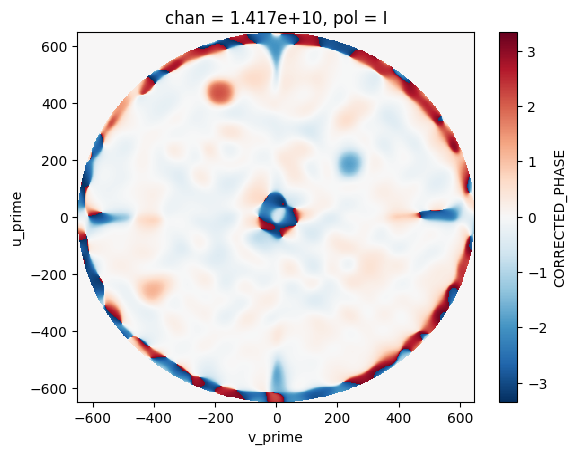

In [10]:
image_mds['ant_ea25']['ddi_0'].CORRECTED_PHASE.isel(chan=0, pol=0).plot()

## Panel

The `panel` function takes the place of and expands the `PANEL` AIPS function to processes the image information and derives adjustements to the dish panels. This produces a file on disk of format `.panel.zarr` containing information on corrections, residuals and screw adjustments. As an added bonus the `panel` function has a helper function to convert aips data to astrohack format and process it using the `aips_holog_to_astrohack` function. For a full description of the operation and arguments of the `panel` function see [docs](https://astrohack.readthedocs.io/en/latest/_api/autoapi/astrohack/panel/index.html).

In [11]:
from astrohack.panel import panel

panel_model = 'rigid'

panel_mds = panel(
    image_name='data/ea25_cal_small_after_fixed.split.image.zarr', 
    panel_model=panel_model, 
    parallel=True,
    overwrite=True
)

2023-06-16 14:06:09,716 - INFO     - astrohack - (_check_parms.py:135) - [panel]: Setting default panel_name to data/ea25_cal_small_after_fixed.split.panel.zarr.
2023-06-16 14:06:09,717 - INFO     - astrohack - (_check_parms.py:135) - [panel]: Setting default ant to all.
2023-06-16 14:06:09,720 - INFO     - astrohack - (_check_parms.py:135) - [panel]: Setting default ddi to all.
2023-06-16 14:06:14,309 - INFO     - astrohack - (panel.py:111) - [panel]: Finished processing


___panel_name.panel.zarr:___ <span style="color:red"> The panel zarr file contains process information regarding the per panel screw corrections as well as residuals, masks and phase corrections used to produce them. The panel file structure is a compound dictionary keyed according to `ant` -> `ddi` with the value consisting of the panel dataset.</span>

```
panel_mds = 
{
   ant_0:{
          ddi_0: panel_ds,
                 ⋮               
          ddi_m: panel_ds
         },
       ⋮
   ant_n: …

```

An example of the panel dataset object is show below.

In [12]:
panel_mds['ant_ea25']['ddi_0']

<xarray.Dataset>
Dimensions:             (u: 442, v: 442, labels: 172, pars: 3, screws: 4)
Coordinates:
  * labels              (labels) object '1-1' '1-2' '1-3' ... '6-39' '6-40'
  * pars                (pars) int64 0 1 2
  * screws              (screws) <U2 'il' 'ir' 'ol' 'or'
  * u                   (u) float64 13.72 13.66 13.6 ... -13.54 -13.6 -13.66
  * v                   (v) float64 -13.72 -13.66 -13.6 ... 13.54 13.6 13.66
Data variables:
    AMPLITUDE           (u, v) float64 dask.array<chunksize=(221, 221), meta=np.ndarray>
    CORRECTIONS         (u, v) float64 dask.array<chunksize=(221, 221), meta=np.ndarray>
    DEVIATION           (u, v) float64 dask.array<chunksize=(221, 221), meta=np.ndarray>
    MASK                (u, v) bool dask.array<chunksize=(442, 442), meta=np.ndarray>
    PANEL_DISTRIBUTION  (u, v) int32 dask.array<chunksize=(221, 221), meta=np.ndarray>
    PANEL_PARAMETERS    (labels, pars) float64 dask.array<chunksize=(172, 3), meta=np.ndarray>
    PANEL_SCREWS        (labels, screws) float64 dask.array<chunksize=(172, 4), meta=np.ndarray>
    PHASE               (u, v) float64 dask.array<chunksize=(221, 221), meta=np.ndarray>
    PHASE_CORRECTIONS   (u, v) float64 dask.array<chunksize=(221, 221), meta=np.ndarray>
    PHASE_RESIDUALS     (u, v) float64 dask.array<chunksize=(221, 221), meta=np.ndarray>
    RESIDUALS           (u, v) float64 dask.array<chunksize=(221, 221), meta=np.ndarray>
Attributes: (12/16)
    amp_unit:             V
    ant_name:             ea25
    aperture_resolution:  [1.3905325544372535, 1.3905325544372535]
    cutoff:               0.7853940125595447
    ddi:                  ddi_0
    fitted:               True
    ...                   ...
    panel_margin:         0.2
    panel_model:          rigid
    solved:               True
    telescope_name:       VLA
    theoretical_gain:     99.60250879986036
    wavelength:           0.021161322651231735

A summary of the available key values can be obtained using the summary convenience function.

In [13]:
panel_mds.summary()

####################################################################################################
###                                         Summary for:                                         ###
###                       data/ea25_cal_small_after_fixed.split.panel.zarr                       ###
####################################################################################################

Attributes:
+---------------+--------------------------------------------------+
| Attribute     | Value                                            |
+---------------+--------------------------------------------------+
| version       | 0.1.6                                            |
| origin        | panel                                            |
| image_name    | data/ea25_cal_small_after_fixed.split.image.zarr |
| panel_name    | data/ea25_cal_small_after_fixed.split.panel.zarr |
| cutoff        | 0.2                                              |
| panel_kind    | rigid        

## Additional Functions

The `panel_mds` object provides two helper functions for the user to export or investigate the results of the `panel` function.
- `export_screws()`: This method exports the screw and panel adjustements from the panel output file.
- `plot_antennae()`: This method plots one of three diagnostics plots from the panel output file data. The plots types are: deviation, phase and ancillary.

Examples usage for each helper functions are given below and more detailed documentation can be found in the [visualization tutorial](https://astrohack.readthedocs.io/en/latest/visualization_tutorial.html).

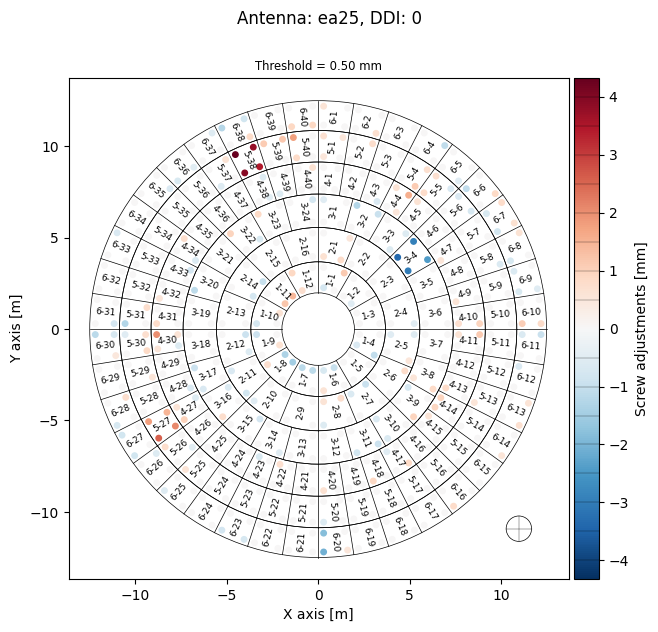

In [14]:
export_folder = 'exports'
panel_mds.export_screws(destination=export_folder,
                        ant_id='ea25',
                        ddi=0,
                        unit='mm',
                        threshold= 0.5, # Threshold in mm for significant adjustments
                       )

In [15]:
with open(export_folder+'/panel_screws_ant_ea25_ddi_0.txt', 'r') as file:
    for _ in range(30):
        print(file.readline()[:-1])

# Screw adjustments for VLA ea25 antenna
# Adjustments are in mm

# Lower means away from subreflector
# Raise means toward the subreflector
# LOWER the panel if the number is POSITIVE
# RAISE the panel if the number is NEGATIVE


Panel           il         ir         ol         or         
1-1           -0.76      -0.13      -0.04       1.13
1-2           -0.38      -0.54       0.46       0.18
1-3            0.34       0.47       0.04       0.30
1-4           -0.26      -0.67      -0.27      -1.05
1-5           -0.45      -0.30      -0.45      -0.17
1-6           -0.99      -0.69       0.00       0.58
1-7           -1.13      -1.15       0.29       0.24
1-8           -1.50      -1.34       0.44       0.74
1-9            0.67       0.16       0.05      -0.91
1-10           0.15       0.64      -0.75       0.16
1-11           1.21       1.44      -0.49      -0.05
1-12           0.72      -0.00       0.90      -0.44
2-1            0.66       0.79       0.33       0.53
2-2           -0.35

2023-06-16 14:06:17,509 - INFO     - astrohack - (_check_parms.py:135) - [plot_antennae]: Setting default unit to mm.
2023-06-16 14:06:17,510 - WARNING  - astrohack - (_dio.py:228) - [plot_antennae]: Destination folder already exists, results may be overwritten


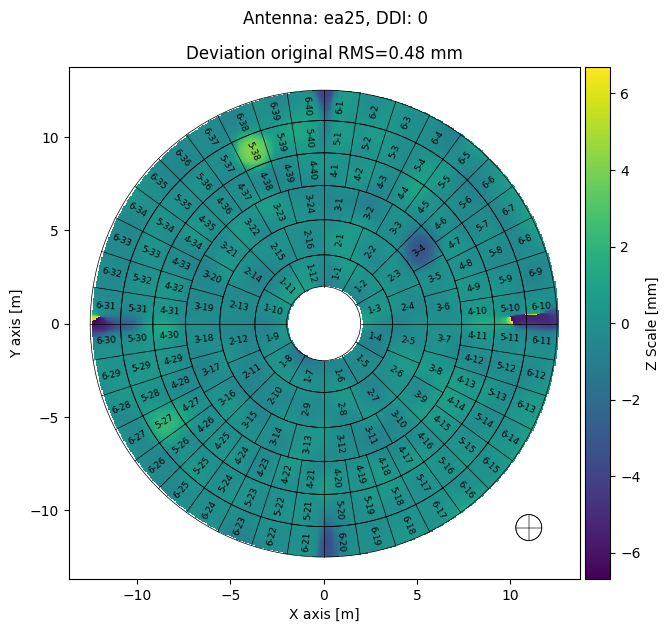

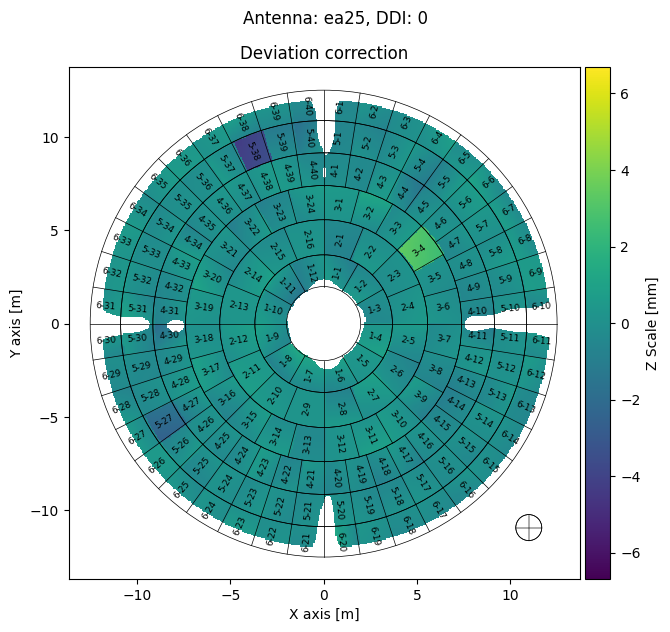

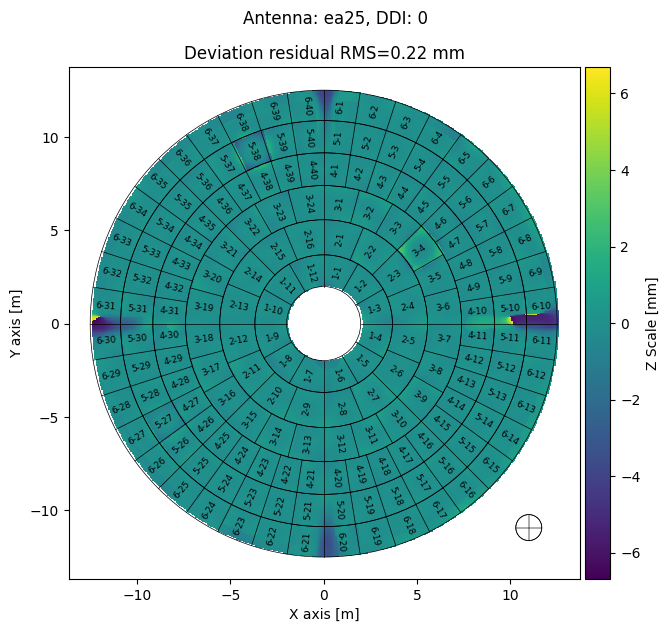

In [16]:
panel_mds.plot_antennae(destination=export_folder,
                        ant_id='ea25', 
                        ddi=0,
                        plot_type='deviation',
                        plot_screws=False,
                        dpi=300,
                        unit=None,
                        parallel=False
                       )